In [49]:
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer, BertModel
from torchtext.legacy.data import Field, LabelField, TabularDataset, BucketIterator
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import json
import time
import random
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_folder = "../data/interim/"

In [51]:
with open("../data/raw/comet_cred.json") as f:
    comet_cred = json.load(f)

In [52]:
hyper_params = {
    "tokenize": "spacy",
    "lower": True,
    "batch_size": 64,
    "hidden_size": 64,
    "embedding_size": 32,
    "num_classes": 3,
    "num_layers": 1,
    "learning_rate": 0.001,
    "min_freq": 5,
    "bidirectional": True,
    "num_epochs": 75,
    "disabled": False,
    "dropout_p": 0.6,
    "save_model_path": "../models/pytorch_model.pt",
    "save_vocab_path": "../models/pytorch_vocab.pkl"
}

In [53]:
# define tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [54]:
# max sentance lenth
max_input_length = 100

In [55]:
def tokenize_and_cut(sentence):
    '''Tokenizes a sentances and removes two characters from maximum length (512)'''
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [56]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

TEXT = Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = LabelField(dtype = torch.float)

101 102 0 100


In [57]:
# Prepare batched data

# first column -> label
# second column -> text
fields = [('label', LABEL), ('text', TEXT)]

train_data, valid_data, test_data = TabularDataset.splits(path=source_folder, train='train_bin_data.csv', validation='dev_bin_data.csv',
                                           test='test_bin_data.csv', format='CSV', fields=fields)
# sort by length of text -> batch of same size sentences
train_iterator = BucketIterator(train_data, batch_size=hyper_params['batch_size'], sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iterator = BucketIterator(valid_data, batch_size=hyper_params['batch_size'], sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iterator = BucketIterator(test_data, batch_size=hyper_params['batch_size'], sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

In [58]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 11713
Number of validation examples: 1465
Number of testing examples: 1465


In [59]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[6])['text'])

print(tokens)

['@', 'united', 'still', 'waiting', 'to', 'hear', 'back', '.', 'my', 'wallet', 'was', 'stolen', 'from', 'one', 'of', 'your', 'planes', 'so', 'would', 'appreciate', 'a', 'resolution', 'here']


In [60]:
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1})


In [61]:
# initialize pretrained model
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [62]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len] 
        
        with torch.no_grad():
            embedded = self.bert(text)[0]       
        #embedded = [batch size, sent len, emb dim]
        _, hidden = self.rnn(embedded)
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])      
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        #output = [batch size, out dim]
        
        return output

In [63]:
# instantiate model

HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.6

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [64]:
## Train Model

In [65]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [66]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


In [67]:
def train(model, iterator, optimizer, criterion):
    
    # metrics
    epoch_loss = 0
    epoch_acc = 0
    test_f1 = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        # sigmoid transform predictions and round
        rounded_preds = torch.round(torch.sigmoid(predictions))
            
        # convert predictions and labels to numpy
        rounded_preds = rounded_preds.cpu().detach().numpy()
        y = batch.label.cpu().detach().numpy()

        loss.backward()
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        test_f1 += f1_score(rounded_preds, y)
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), test_f1 / len(iterator)

In [68]:
def evaluate(model, iterator, criterion):
    
    # metrics
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    # predictions and lables
    all_preds = np.array([])
    all_y = np.array([])
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            # batch predictions and labels
            predictions = model(batch.text).squeeze(1)
            labels = batch.label
            
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, labels)
            
            # sigmoid transform predictions and round
            rounded_preds = torch.round(torch.sigmoid(predictions))
            
            # convert predictions and labels to numpy
            rounded_preds = rounded_preds.cpu().detach().numpy()
            y = labels.cpu().detach().numpy()
            
            # append predictions and labels
            all_preds = np.append(all_preds, rounded_preds)
            all_y = np.append(all_y, y)
            
            # update metrics
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1_score(rounded_preds, y)
    
    # final report
    print(classification_report(all_y, all_preds))
    
    # confusion matrix
    cm = confusion_matrix(all_y, all_preds, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['NEGATIVE', 'POSITIVE'])
    ax.yaxis.set_ticklabels(['NEGATIVE', 'POSITIVE'])
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [69]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1220
         1.0       0.89      0.45      0.60       245

    accuracy                           0.90      1465
   macro avg       0.89      0.72      0.77      1465
weighted avg       0.90      0.90      0.88      1465

Epoch: 01 | Epoch Time: 9m 38s
	Train Loss: 0.236 | Train Acc: 90.42% | Train f1: 0.64
	 Val. Loss: 0.248 | Val. Acc: 89.85%  | Val. Acc: 0.53


/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      1220
         1.0       0.83      0.72      0.77       245

    accuracy                           0.93      1465
   macro avg       0.89      0.84      0.86      1465
weighted avg       0.93      0.93      0.93      1465

Epoch: 02 | Epoch Time: 9m 29s
	Train Loss: 0.195 | Train Acc: 92.51% | Train f1: 0.71
	 Val. Loss: 0.187 | Val. Acc: 92.84%  | Val. Acc: 0.70


/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1220
         1.0       0.74      0.80      0.77       245

    accuracy                           0.92      1465
   macro avg       0.85      0.87      0.86      1465
weighted avg       0.92      0.92      0.92      1465

Epoch: 03 | Epoch Time: 9m 31s
	Train Loss: 0.171 | Train Acc: 93.44% | Train f1: 0.76
	 Val. Loss: 0.185 | Val. Acc: 92.03%  | Val. Acc: 0.72


/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1220
         1.0       0.82      0.76      0.79       245

    accuracy                           0.93      1465
   macro avg       0.89      0.86      0.87      1465
weighted avg       0.93      0.93      0.93      1465

Epoch: 04 | Epoch Time: 9m 28s
	Train Loss: 0.162 | Train Acc: 93.79% | Train f1: 0.78
	 Val. Loss: 0.189 | Val. Acc: 93.12%  | Val. Acc: 0.72


/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jahnic/Git/Portfolio/AgileProject/twitter_sentiment/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      1220
         1.0       0.86      0.66      0.74       245

    accuracy                           0.92      1465
   macro avg       0.90      0.82      0.85      1465
weighted avg       0.92      0.92      0.92      1465

Epoch: 05 | Epoch Time: 9m 27s
	Train Loss: 0.142 | Train Acc: 94.53% | Train f1: 0.79
	 Val. Loss: 0.242 | Val. Acc: 92.43%  | Val. Acc: 0.67


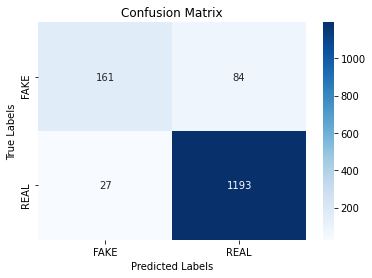

In [70]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../models/binary_transformer_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train f1: {train_f1:.2f}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%  | Val. f1: {valid_f1:.2f}')

In [71]:
# load best model

model.load_state_dict(torch.load('../models/binary_transformer_model.pt'))

<All keys matched successfully>

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      1243
         1.0       0.74      0.74      0.74       222

    accuracy                           0.92      1465
   macro avg       0.84      0.85      0.84      1465
weighted avg       0.92      0.92      0.92      1465

Test Loss: 0.205 | Test Acc: 91.99% | Test F1: 0.70


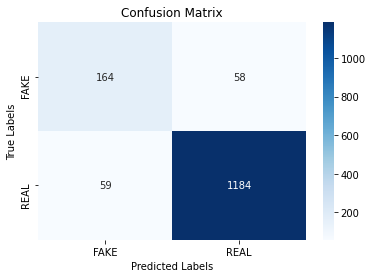

In [72]:
# try model on test set

test_loss, test_acc, test_f1 = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.2f}')